In [9]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Đường dẫn tới thư mục chứa các file txt ===
folder = "baseline_results"

data = []

for filename in os.listdir(folder):
    if not filename.endswith(".txt"):
        continue

    filepath = os.path.join(folder, filename)

    # Tách tên file theo template model_technique_task
    parts = filename.replace(".txt", "").split("_")
    if len(parts) >= 3:
        model = parts[0]
        task = parts[-1]
        technique = "_".join(parts[1:-1])
    else:
        continue

    with open(filepath, "r", encoding="utf-8") as f:
        content = f.read()

    # --- Phân loại loại kết quả ---
    if "accuracy" in content or "precision" in content:  # classification_report
        # Tìm accuracy trong phần báo cáo
        match = re.search(r"accuracy\s+([\d\.]+)", content)
        accuracy = float(match.group(1)) if match else None
        data.append({
            "model": model,
            "technique": technique,
            "task": task,
            "metric": "accuracy",
            "value": accuracy
        })

    elif "MAE" in content:  # regression result
        match = re.search(r"MAE[:\s]+([\d\.]+)", content)
        mae = float(match.group(1)) if match else None
        data.append({
            "model": model,
            "technique": technique,
            "task": task,
            "metric": "MAE",
            "value": mae
        })

# === Tạo DataFrame tổng hợp ===
df = pd.DataFrame(data)
print(df)

# === Lưu lại nếu cần ===
df.to_csv("summary_results.csv", index=False)


    model                   technique      task    metric     value
0     KNN  hpcb-kmeans_anon_template1   avgpcon       MAE   29.4441
1     KNN  hpcb-kmeans_anon_template1  duration       MAE  261.8585
2     KNN  hpcb-kmeans_anon_template1        ec  accuracy    0.8400
3     KNN  hpcb-kmeans_anon_template1    pclass  accuracy    0.8300
4     KNN                    int_anon   avgpcon       MAE   29.3223
..    ...                         ...       ...       ...       ...
115   XGB           sb_anon_template6    pclass  accuracy    0.7300
116   XGB                          sb   avgpcon       MAE   36.2939
117   XGB                          sb  duration       MAE  461.2847
118   XGB                          sb        ec  accuracy    0.7900
119   XGB                          sb    pclass  accuracy    0.8400

[120 rows x 5 columns]


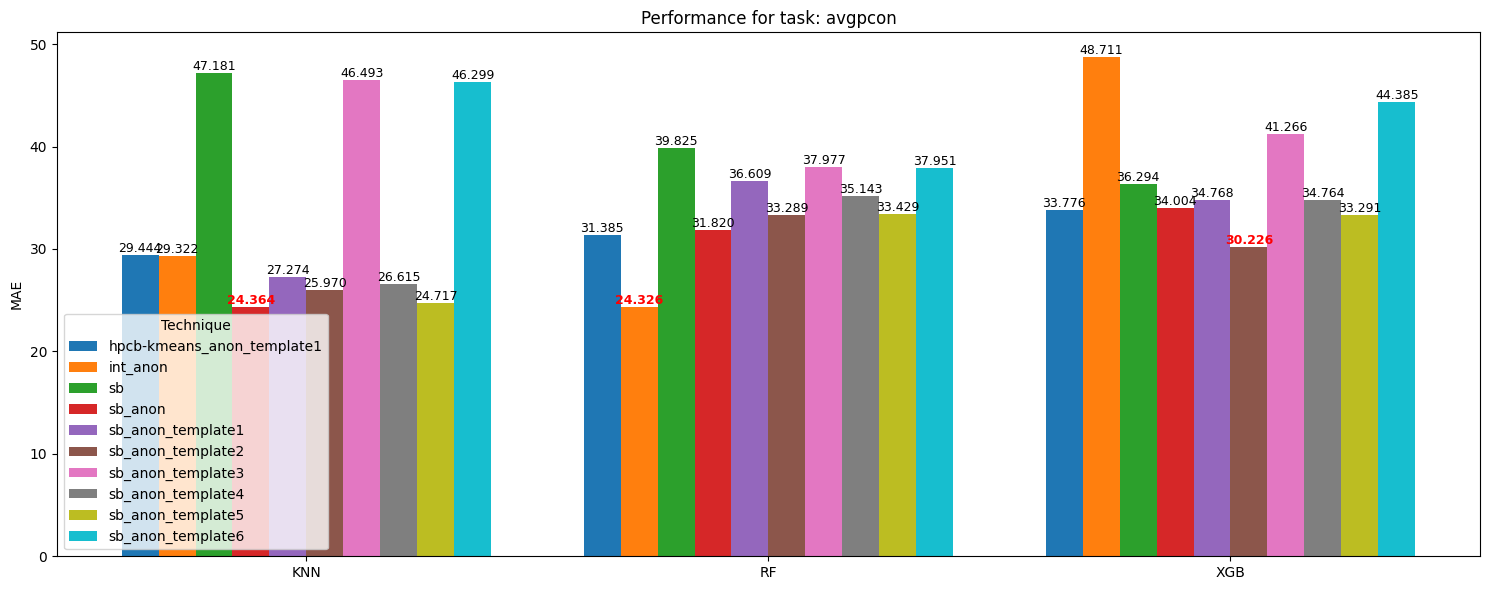

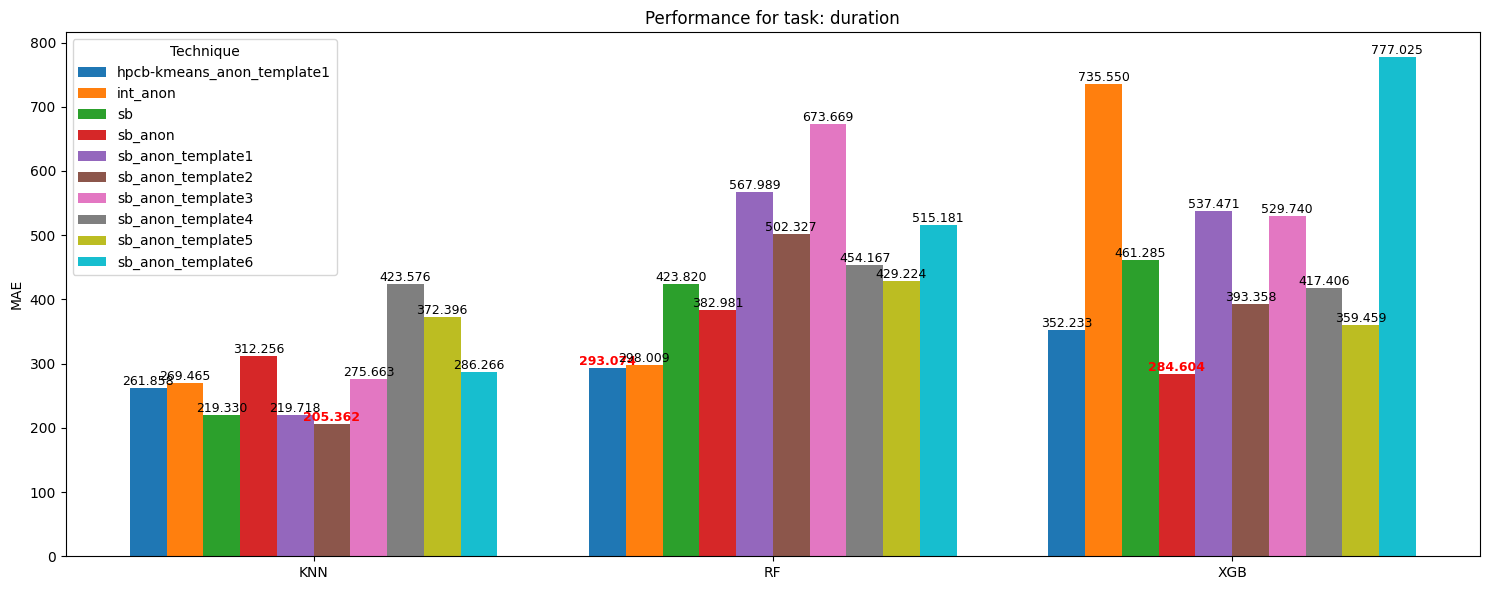

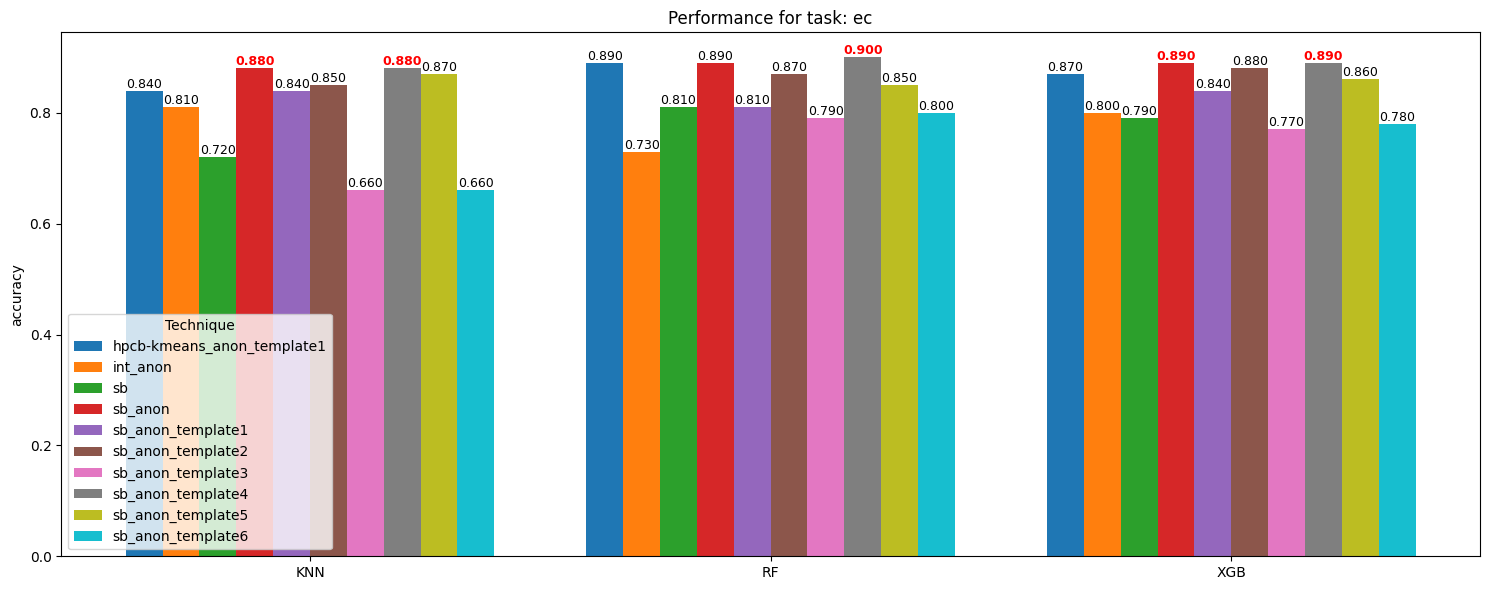

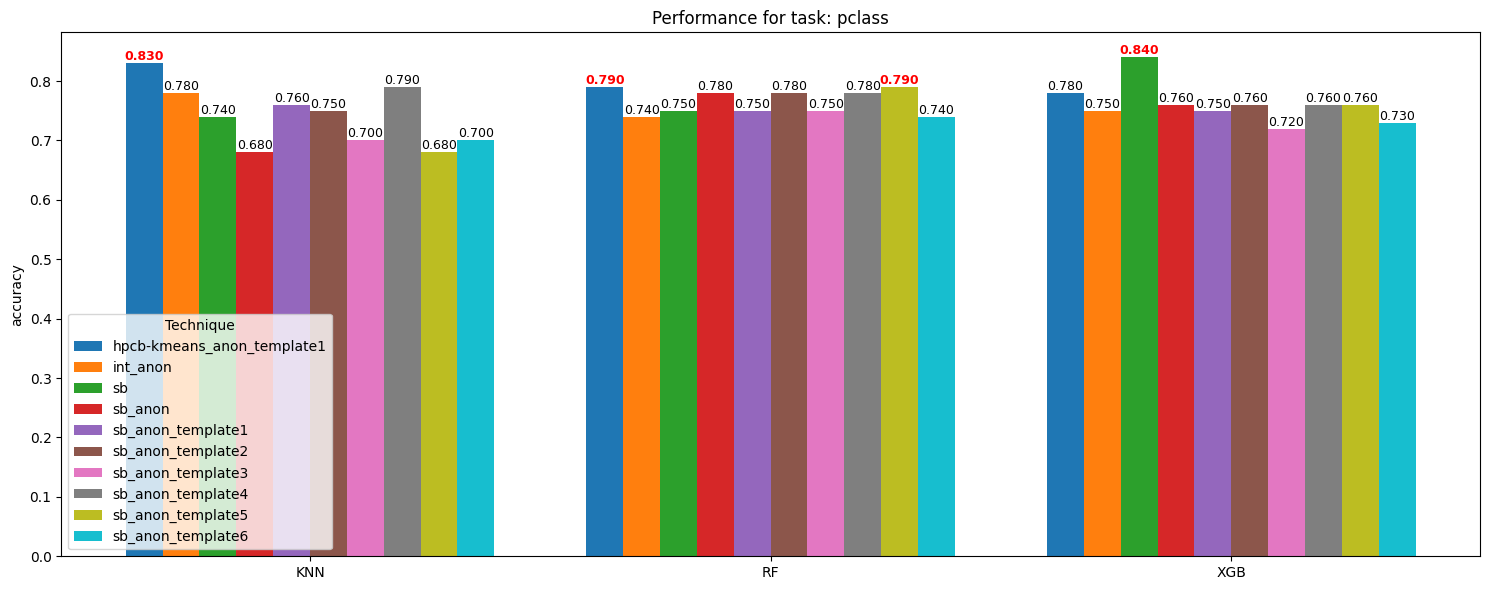

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Các metric cần MIN thay vì MAX
minimize_metrics = {"mae", "rmse", "mse", "loss", "error"}

for task in df["task"].unique():
    subset = df[df["task"] == task].sort_values(["model", "technique"])

    models = subset["model"].unique()
    techniques = subset["technique"].unique()
    metric_name = subset["metric"].iloc[0].lower()

    x = np.arange(len(models))
    width = 0.8 / max(1, len(techniques))

    plt.figure(figsize=(15, 6))

    # Chọn hàm min/max tùy metric
    if any(m in metric_name for m in minimize_metrics):
        best_values = subset.groupby("model")["value"].min().to_dict()
        better = lambda val, best: np.isclose(val, best) or val <= best
    else:
        best_values = subset.groupby("model")["value"].max().to_dict()
        better = lambda val, best: np.isclose(val, best) or val >= best

    # Vẽ từng technique (align values to full models list to avoid shape mismatch)
    for i, tech in enumerate(techniques):
        sub_t = subset[subset["technique"] == tech]
        # build values aligned to 'models' order; use np.nan for missing model-tech combos
        values = np.array([sub_t[sub_t["model"] == m]["value"].values[0]
                           if len(sub_t[sub_t["model"] == m]) > 0 else np.nan
                           for m in models])
        positions = x + (i - len(techniques)/2) * width + width/2
        bars = plt.bar(positions, values, width, label=tech)

        # Gắn nhãn; skip missing (NaN) entries to keep lengths consistent
        for bar, val, model in zip(bars, values, models):
            if np.isnan(val):
                continue
            height = bar.get_height()
            if better(val, best_values.get(model, val)):
                plt.text(
                    bar.get_x() + bar.get_width()/2,
                    height,
                    f"{height:.3f}",
                    ha="center", va="bottom",
                    fontsize=9, color="red", fontweight="bold"
                )
            else:
                plt.text(
                    bar.get_x() + bar.get_width()/2,
                    height,
                    f"{height:.3f}",
                    ha="center", va="bottom", fontsize=9
                )

    plt.xticks(x, models, rotation=0)
    plt.title(f"Performance for task: {task}")
    plt.ylabel(subset["metric"].iloc[0])
    plt.legend(title="Technique")
    plt.tight_layout()
    plt.show()


```python
semantic_templates = [
        # Template 1: Cấu trúc bị động rút gọn (Compact Passive Construction)
        # Diễn đạt hành động “submit” ở dạng bị động nhằm đa dạng hóa ngữ pháp và trật tự thông tin.
        # Câu mô tả ngắn gọn, đưa "Job" lên đầu để nhấn mạnh đối tượng công việc, đồng thời vẫn giữ đủ ba thực thể: user – job – environment.
        lambda r: f"Job submitted by user {r['usr']} with name {r['jnam']} requiring environment {r['jobenv_req']}.",

        # Template 2: Tập trung vào Chủ thể/Hành động cơ bản (User–Job–Environment Relation)
        # Mô tả trực tiếp mối quan hệ giữa người dùng (user), công việc (job) và môi trường tính toán (environment).
        # Cấu trúc đơn giản, dễ hiểu, giúp mô hình học được ngữ cảnh cơ bản của hành động “submit”.
        lambda r: f"The user profile {r['usr']} submitted a computation {r['jnam']} to the environment {r['jobenv_req']}.",
        
        # Template 3: Tập trung vào Ngữ cảnh/Môi trường (Environment Focus)
        # Nhấn mạnh rằng môi trường được yêu cầu cho một tác vụ cụ thể của người dùng.
        lambda r: f"The high-priority computational environment {r['jobenv_req']} was specifically requested by user {r['usr']} for running the job named {r['jnam']}.",
        
        # Template 4: Tập trung vào Đối tượng/Công việc (Job Focus)
        # Nhấn mạnh tính chất của Job và vai trò của User/Environment đối với Job đó.
        lambda r: f"Job {r['jnam']}, which will be executed by {r['usr']}, requires exclusive access to the infrastructure {r['jobenv_req']}.",
        
        # Template 5: Mối quan hệ Hành động & Liên kết (Action & Association)
        # Dùng các động từ mạnh hơn để mô tả hành động lập lịch/chạy.
        lambda r: f"The scheduling system recorded that {r['usr']} is deploying job {r['jnam']} onto the {r['jobenv_req']} partition.",
        
        # Template 6: Cú pháp bị động (Passive Voice)
        # Thử nghiệm các cấu trúc câu khác để buộc mô hình học các phụ thuộc khác.
        lambda r: f"The hardware configuration {r['jobenv_req']} is being utilized by job {r['jnam']} which was initialized by {r['usr']}."
    ]
```

🧠 Task: avgpcon

| Model   | Template 2   | Template 4 | hpcb-template2 | hpcb-template4 | hpcb-kmeans-template4 |
| ------- | ------------ | ---------- | -------------- | -------------- | -------------- |
| **KNN** | Top 3        | Top 4      | Top 6          | Top 5          | Top 7          |
| **RF**  | Top 3        | Top 5      | Top 3          | Top 2          | Top 2          |
| **XG**  | 🥇 **Top 1** | Top 4      | Top 2          | Top 3          | Top 3          |


⏱️ Task: duration

| Model   | Template 2   | Template 4 | hpcb-template2 | hpcb-template4 | hpcb-kmeans-template4 |
| ------- | ------------ | ---------- | -------------- | -------------- | -------------- |
| **KNN** | 🥇 **Top 1** | Top 9      | Top 2          | 🥇 **Top 1**   | Top 4          |
| **RF**  | Top 6        | Top 5      | 🥇 **Top 1**   | Top 2          | Top 1          |
| **XG**  | Top 3        | Top 4      | Top 3          | 🥇 **Top 1**   | Top 2          |

⚡ Task: ec

| Model   | Template 2   | Template 4 | hpcb-template2 | hpcb-template4 | hpcb-kmeans-template4 |
| ------- | ------------ | ---------- | -------------- | -------------- | -------------- |
| **KNN** | Top 4        | 🥇 **Top 1** | Top 5          | Top 7          | Top 5          |
| **RF**  | Top 3        | 🥇 **Top 1** | Top 4          | Top 4          | Top 2          |
| **XG**  | Top 3        | 🥇 **Top 1** | 🥇 **Top 1**   | 🥇 **Top 1**   | Top 4          |

📊 Task: pclass

| Model   | Template 2 | Template 4   | hpcb-template2 | hpcb-template4 | hpcb-kmeans-template4 |
| ------- | ---------- | ------------ | -------------- | -------------- | -------------- |
| **KNN** | Top 4      | 🥇 **Top 1** | Top 5          | Top 7          | Top 1          |
| **RF**  | Top 2      | Top 2        | Top 2          | Top 2          | Top 1          |
| **XG**  | Top 2      | Top 2        | Top 3           | Top 2        | Top 2          |